In [1]:
import numpy as np
import cv2
import scipy.io
import os
from numpy.linalg import norm
from matplotlib import pyplot as plt
from numpy.linalg import det
from numpy.linalg import inv
from scipy.linalg import rq
from numpy.linalg import svd
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import sys
from scipy import ndimage, spatial
from tqdm.notebook import tqdm, trange

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from skimage import io, transform,data
from torchvision import transforms, utils
import numpy as np
import math
import glob
import matplotlib.pyplot as plt
import time
import os
import copy
import sklearn.svm
import cv2
from matplotlib import pyplot as plt
import numpy as np
from os.path import exists
import pandas as pd
import PIL
import random
from google.colab import drive
from sklearn.metrics.cluster import completeness_score
from sklearn.cluster import KMeans
from tqdm import tqdm, tqdm_notebook
from functools import partial
from torchsummary import summary
from torchvision.datasets import ImageFolder
from torch.utils.data.sampler import SubsetRandomSampler

#cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
#accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

#print("Accelerator type = ",accelerator)
#print("Pytorch verision: ", torch.__version__)

In [2]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install opencv-python==3.4.2.17
!pip install opencv-contrib-python==3.4.2.17

In [3]:
class Image:
    def __init__(self, img, position):
        
        self.img = img
        self.position = position

inlier_matchset = []
def features_matching(a,keypointlength,threshold):
  #threshold=0.2
  bestmatch=np.empty((keypointlength),dtype= np.int16)
  img1index=np.empty((keypointlength),dtype=np.int16)
  distance=np.empty((keypointlength))
  index=0
  for j in range(0,keypointlength):
    #For a descriptor fa in Ia, take the two closest descriptors fb1 and fb2 in Ib
    x=a[j]
    listx=x.tolist()
    x.sort()
    minval1=x[0]                                # min 
    minval2=x[1]                                # 2nd min
    itemindex1 = listx.index(minval1)           #index of min val    
    itemindex2 = listx.index(minval2)           #index of second min value 
    ratio=minval1/minval2                       #Ratio Test
    
    if ratio<threshold: 
      #Low distance ratio: fb1 can be a good match
      bestmatch[index]=itemindex1
      distance[index]=minval1
      img1index[index]=j
      index=index+1
  return  [cv2.DMatch(img1index[i],bestmatch[i].astype(int),distance[i]) for i in range(0,index)]
          
   
  
def compute_Homography(im1_pts,im2_pts):
  """
  im1_pts and im2_pts are 2×n matrices with
  4 point correspondences from the two images
  """
  num_matches=len(im1_pts)
  num_rows = 2 * num_matches
  num_cols = 9
  A_matrix_shape = (num_rows,num_cols)
  A = np.zeros(A_matrix_shape)
  a_index = 0
  for i in range(0,num_matches):
    (a_x, a_y) = im1_pts[i]
    (b_x, b_y) = im2_pts[i]
    row1 = [a_x, a_y, 1, 0, 0, 0, -b_x*a_x, -b_x*a_y, -b_x] # First row 
    row2 = [0, 0, 0, a_x, a_y, 1, -b_y*a_x, -b_y*a_y, -b_y] # Second row 

    # place the rows in the matrix
    A[a_index] = row1
    A[a_index+1] = row2

    a_index += 2
    
  U, s, Vt = np.linalg.svd(A)

  #s is a 1-D array of singular values sorted in descending order
  #U, Vt are unitary matrices
  #Rows of Vt are the eigenvectors of A^TA.
  #Columns of U are the eigenvectors of AA^T.
  H = np.eye(3)
  H = Vt[-1].reshape(3,3) # take the last row of the Vt matrix
  return H
  
  
def displayplot(img,title):
  
  plt.figure(figsize=(15,15))
  plt.title(title)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.show()

In [4]:
def get_inliers(f1, f2, matches, H, RANSACthresh):

  inlier_indices = []
  for i in range(len(matches)):
    queryInd = matches[i].queryIdx
    trainInd = matches[i].trainIdx

    #queryInd = matches[i][0]
    #trainInd = matches[i][1]

    queryPoint = np.array([f1[queryInd].pt[0],  f1[queryInd].pt[1], 1]).T 
    trans_query = H.dot(queryPoint) 

   
    comp1 = [trans_query[0]/trans_query[2], trans_query[1]/trans_query[2]] # normalize with respect to z
    comp2 = np.array(f2[trainInd].pt)[:2]
    

    if(np.linalg.norm(comp1-comp2) <= RANSACthresh): # check against threshold
      inlier_indices.append(i)
  return inlier_indices


def RANSAC_alg(f1, f2, matches, nRANSAC, RANSACthresh):

      
    minMatches = 4
    nBest = 0
    best_inliers = []
    H_estimate = np.eye(3,3)
    global inlier_matchset
    inlier_matchset=[]
    for iteration in range(nRANSAC):
      
        #Choose a minimal set of feature matches.
        matchSample = random.sample(matches, minMatches)
        
        #Estimate the Homography implied by these matches
        im1_pts=np.empty((minMatches,2))
        im2_pts=np.empty((minMatches,2))
        for i in range(0,minMatches):
          m = matchSample[i]
          im1_pts[i] = f1[m.queryIdx].pt
          im2_pts[i] = f2[m.trainIdx].pt
          #im1_pts[i] = f1[m[0]].pt
          #im2_pts[i] = f2[m[1]].pt             
          
        H_estimate=compute_Homography(im1_pts,im2_pts)
        
               
        # Calculate the inliers for the H
        inliers = get_inliers(f1, f2, matches, H_estimate, RANSACthresh)

        # if the number of inliers is higher than previous iterations, update the best estimates
        if len(inliers) > nBest:
            nBest= len(inliers)
            best_inliers = inliers

    print("Number of best inliers",len(best_inliers))
    for i in range(len(best_inliers)):
      inlier_matchset.append(matches[best_inliers[i]])
    
    # compute a homography given this set of matches
    im1_pts=np.empty((len(best_inliers),2))
    im2_pts=np.empty((len(best_inliers),2))
    for i in range(0,len(best_inliers)):
      m = inlier_matchset[i]
      im1_pts[i] = f1[m.queryIdx].pt
      im2_pts[i] = f2[m.trainIdx].pt
      #im1_pts[i] = f1[m[0]].pt
      #im2_pts[i] = f2[m[1]].pt

    M=compute_Homography(im1_pts,im2_pts)
    return M, best_inliers

In [5]:
tqdm = partial(tqdm, position=0, leave=True)

In [6]:
files_all=[]
for file in os.listdir("/content/drive/MyDrive/RGB-img/img/"):
    if file.endswith(".JPG"):
      files_all.append(file)


files_all.sort()
folder_path = '/content/drive/MyDrive/RGB-img/img/'

centre_file = folder_path + files_all[50]
left_files_path_rev = []
right_files_path = []

for file in files_all[:61]:
  left_files_path_rev.append(folder_path + file)

left_files_path = left_files_path_rev[::-1]

for file in files_all[60:120]:
  right_files_path.append(folder_path + file)

In [7]:
gridsize = 8
clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(gridsize,gridsize))

images_left_bgr = []
images_right_bgr = []

images_left = []
images_right = []

for file in tqdm(left_files_path):
  left_image_sat= cv2.imread(file)
  #lab = cv2.cvtColor(left_image_sat, cv2.COLOR_BGR2LAB)
  #lab[...,0] = clahe.apply(lab[...,0])
  #left_image_sat = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
  left_img = cv2.resize(left_image_sat,None,fx=0.3, fy=0.3, interpolation = cv2.INTER_CUBIC)
  images_left.append(cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY).astype('float32')/255.)
  images_left_bgr.append(left_img)


for file in tqdm(right_files_path):
  right_image_sat= cv2.imread(file)
  #lab = cv2.cvtColor(right_image_sat, cv2.COLOR_BGR2LAB)
  #lab[...,0] = clahe.apply(lab[...,0])
  #right_image_sat = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
  right_img = cv2.resize(right_image_sat,None,fx=0.3,fy=0.3, interpolation = cv2.INTER_CUBIC)
  images_right.append(cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY).astype('float32')/255.)
  images_right_bgr.append(right_img)

100%|██████████| 60/60 [00:23<00:00,  2.55it/s]


In [8]:
images_left_bgr_no_enhance = []
images_right_bgr_no_enhance = []

for file in tqdm(left_files_path):
  left_image_sat= cv2.imread(file)
  left_img = cv2.resize(left_image_sat,None,fx=0.35, fy=0.35, interpolation = cv2.INTER_CUBIC)
  images_left_bgr_no_enhance.append(left_img)


for file in tqdm(right_files_path):
  right_image_sat= cv2.imread(file)
  right_img = cv2.resize(right_image_sat,None,fx=0.35,fy=0.35, interpolation = cv2.INTER_CUBIC)
  images_right_bgr_no_enhance.append(right_img)

100%|██████████| 60/60 [00:23<00:00,  2.52it/s]


In [9]:
!git clone https://github.com/magicleap/SuperPointPretrainedNetwork.git

fatal: destination path 'SuperPointPretrainedNetwork' already exists and is not an empty directory.


In [10]:
weights_path = 'SuperPointPretrainedNetwork/superpoint_v1.pth'

cuda = 'True'

In [11]:
def to_kpts(pts, size=1):
  return [cv2.KeyPoint(pt[0], pt[1], size) for pt in pts]

In [12]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.cuda.empty_cache()

class SuperPointNet(nn.Module):
    def __init__(self):
        super(SuperPointNet, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        c1, c2, c3, c4, c5, d1 = 64, 64, 128, 128, 256, 256
        # Shared Encoder.
        self.conv1a = nn.Conv2d(1, c1, kernel_size=3, stride=1, padding=1)
        self.conv1b = nn.Conv2d(c1, c1, kernel_size=3, stride=1, padding=1)
        self.conv2a = nn.Conv2d(c1, c2, kernel_size=3, stride=1, padding=1)
        self.conv2b = nn.Conv2d(c2, c2, kernel_size=3, stride=1, padding=1)
        self.conv3a = nn.Conv2d(c2, c3, kernel_size=3, stride=1, padding=1)
        self.conv3b = nn.Conv2d(c3, c3, kernel_size=3, stride=1, padding=1)
        self.conv4a = nn.Conv2d(c3, c4, kernel_size=3, stride=1, padding=1)
        self.conv4b = nn.Conv2d(c4, c4, kernel_size=3, stride=1, padding=1)
        # Detector Head.
        self.convPa = nn.Conv2d(c4, c5, kernel_size=3, stride=1, padding=1)
        self.convPb = nn.Conv2d(c5, 65, kernel_size=1, stride=1, padding=0)
        # Descriptor Head.
        self.convDa = nn.Conv2d(c4, c5, kernel_size=3, stride=1, padding=1)
        self.convDb = nn.Conv2d(c5, d1, kernel_size=1, stride=1, padding=0)

    def forward(self, x):

        # Shared Encoder.
        x = self.relu(self.conv1a(x))
        x = self.relu(self.conv1b(x))
        x = self.pool(x)
        x = self.relu(self.conv2a(x))
        x = self.relu(self.conv2b(x))
        x = self.pool(x)
        x = self.relu(self.conv3a(x))
        x = self.relu(self.conv3b(x))
        x = self.pool(x)
        x = self.relu(self.conv4a(x))
        x = self.relu(self.conv4b(x))
        # Detector Head.
        cPa = self.relu(self.convPa(x))
        semi = self.convPb(cPa)
        # Descriptor Head.
        cDa = self.relu(self.convDa(x))
        desc = self.convDb(cDa)
        dn = torch.norm(desc, p=2, dim=1) # Compute the norm.
        desc = desc.div(torch.unsqueeze(dn, 1)) # Divide by norm to normalize.
        return semi, desc


class SuperPointFrontend(object):
    def __init__(self, weights_path, nms_dist, conf_thresh, nn_thresh,cuda=True):
        self.name = 'SuperPoint'
        self.cuda = cuda
        self.nms_dist = nms_dist
        self.conf_thresh = conf_thresh
        self.nn_thresh = nn_thresh # L2 descriptor distance for good match.
        self.cell = 8 # Size of each output cell. Keep this fixed.
        self.border_remove = 4 # Remove points this close to the border.

        # Load the network in inference mode.
        self.net = SuperPointNet()
        if cuda:
          # Train on GPU, deploy on GPU.
            self.net.load_state_dict(torch.load(weights_path))
            self.net = self.net.cuda()
        else:
          # Train on GPU, deploy on CPU.
            self.net.load_state_dict(torch.load(weights_path, map_location=lambda storage, loc: storage))
        self.net.eval()

    def nms_fast(self, in_corners, H, W, dist_thresh):

        grid = np.zeros((H, W)).astype(int) # Track NMS data.
        inds = np.zeros((H, W)).astype(int) # Store indices of points.
        # Sort by confidence and round to nearest int.
        inds1 = np.argsort(-in_corners[2,:])
        corners = in_corners[:,inds1]
        rcorners = corners[:2,:].round().astype(int) # Rounded corners.
        # Check for edge case of 0 or 1 corners.
        if rcorners.shape[1] == 0:
            return np.zeros((3,0)).astype(int), np.zeros(0).astype(int)
        if rcorners.shape[1] == 1:
            out = np.vstack((rcorners, in_corners[2])).reshape(3,1)
            return out, np.zeros((1)).astype(int)
        # Initialize the grid.
        for i, rc in enumerate(rcorners.T):
            grid[rcorners[1,i], rcorners[0,i]] = 1
            inds[rcorners[1,i], rcorners[0,i]] = i
        # Pad the border of the grid, so that we can NMS points near the border.
        pad = dist_thresh
        grid = np.pad(grid, ((pad,pad), (pad,pad)), mode='constant')
        # Iterate through points, highest to lowest conf, suppress neighborhood.
        count = 0
        for i, rc in enumerate(rcorners.T):
          # Account for top and left padding.
            pt = (rc[0]+pad, rc[1]+pad)
            if grid[pt[1], pt[0]] == 1: # If not yet suppressed.
                grid[pt[1]-pad:pt[1]+pad+1, pt[0]-pad:pt[0]+pad+1] = 0
                grid[pt[1], pt[0]] = -1
                count += 1
        # Get all surviving -1's and return sorted array of remaining corners.
        keepy, keepx = np.where(grid==-1)
        keepy, keepx = keepy - pad, keepx - pad
        inds_keep = inds[keepy, keepx]
        out = corners[:, inds_keep]
        values = out[-1, :]
        inds2 = np.argsort(-values)
        out = out[:, inds2]
        out_inds = inds1[inds_keep[inds2]]
        return out, out_inds

    def run(self, img):
        assert img.ndim == 2 #Image must be grayscale.
        assert img.dtype == np.float32 #Image must be float32.
        H, W = img.shape[0], img.shape[1]
        inp = img.copy()
        inp = (inp.reshape(1, H, W))
        inp = torch.from_numpy(inp)
        inp = torch.autograd.Variable(inp).view(1, 1, H, W)
        if self.cuda:
            inp = inp.cuda()
        # Forward pass of network.
        outs = self.net.forward(inp)
        semi, coarse_desc = outs[0], outs[1]
        # Convert pytorch -> numpy.
        semi = semi.data.cpu().numpy().squeeze()
        
        # --- Process points.
        dense = np.exp(semi) # Softmax.
        dense = dense / (np.sum(dense, axis=0)+.00001) # Should sum to 1.
        nodust = dense[:-1, :, :]
        # Reshape to get full resolution heatmap.
        Hc = int(H / self.cell)
        Wc = int(W / self.cell)
        nodust = np.transpose(nodust, [1, 2, 0])
        heatmap = np.reshape(nodust, [Hc, Wc, self.cell, self.cell])
        heatmap = np.transpose(heatmap, [0, 2, 1, 3])
        heatmap = np.reshape(heatmap, [Hc*self.cell, Wc*self.cell]) 
        prob_map = heatmap/np.sum(np.sum(heatmap))
        
        return heatmap, coarse_desc


    def key_pt_sampling(self, img, heat_map, coarse_desc, sampled):
        
        H, W = img.shape[0], img.shape[1]

        xs, ys = np.where(heat_map >= self.conf_thresh) # Confidence threshold.
        if len(xs) == 0:
            return np.zeros((3, 0)), None, None
        print("number of pts selected :", len(xs))
        
        
        pts = np.zeros((3, len(xs))) # Populate point data sized 3xN.
        pts[0, :] = ys
        pts[1, :] = xs
        pts[2, :] = heat_map[xs, ys]
        pts, _ = self.nms_fast(pts, H, W, dist_thresh=self.nms_dist) # Apply NMS.
        inds = np.argsort(pts[2,:])
        pts = pts[:,inds[::-1]] # Sort by confidence.
        bord = self.border_remove
        toremoveW = np.logical_or(pts[0, :] < bord, pts[0, :] >= (W-bord))
        toremoveH = np.logical_or(pts[1, :] < bord, pts[1, :] >= (H-bord))
        toremove = np.logical_or(toremoveW, toremoveH)
        pts = pts[:, ~toremove]
        pts = pts[:,0:sampled] #we take 2000 keypoints with highest probability from heatmap for our benchmark
        
        # --- Process descriptor.
        D = coarse_desc.shape[1]
        if pts.shape[1] == 0:
            desc = np.zeros((D, 0))
        else:
          # Interpolate into descriptor map using 2D point locations.
            samp_pts = torch.from_numpy(pts[:2, :].copy())
            samp_pts[0, :] = (samp_pts[0, :] / (float(W)/2.)) - 1.
            samp_pts[1, :] = (samp_pts[1, :] / (float(H)/2.)) - 1.
            samp_pts = samp_pts.transpose(0, 1).contiguous()
            samp_pts = samp_pts.view(1, 1, -1, 2)
            samp_pts = samp_pts.float()
            if self.cuda:
                samp_pts = samp_pts.cuda()            
            desc = nn.functional.grid_sample(coarse_desc, samp_pts)
            desc = desc.data.cpu().numpy().reshape(D, -1)
            desc /= np.linalg.norm(desc, axis=0)[np.newaxis, :]

            
        return pts, desc

In [13]:
print('Loading pre-trained network.')
# This class runs the SuperPoint network and processes its outputs.
fe = SuperPointFrontend(weights_path=weights_path,nms_dist = 3,conf_thresh = 0.01,nn_thresh=0.5)
print('Successfully loaded pre-trained network.')

Loading pre-trained network.
Successfully loaded pre-trained network.


In [14]:
keypoints_all_left_superpoint = []
descriptors_all_left_superpoint = []
points_all_left_superpoint=[]

keypoints_all_right_superpoint = []
descriptors_all_right_superpoint = []
points_all_right_superpoint=[]

tqdm = partial(tqdm, position=0, leave=True)

for lfpth in tqdm(images_left):
  heatmap1, coarse_desc1 = fe.run(lfpth)
  pts_1, desc_1 = fe.key_pt_sampling(lfpth, heatmap1, coarse_desc1, 80000) #Getting keypoints and descriptors for 1st image

  keypoints_all_left_superpoint.append(to_kpts(pts_1.T))
  descriptors_all_left_superpoint.append(desc_1.T)
  points_all_left_superpoint.append(pts_1.T)


for rfpth in tqdm(images_right):
  heatmap1, coarse_desc1 = fe.run(rfpth)
  pts_1, desc_1 = fe.key_pt_sampling(rfpth, heatmap1, coarse_desc1, 80000) #Getting keypoints and descriptors for 1st image

  keypoints_all_right_superpoint.append(to_kpts(pts_1.T))
  descriptors_all_right_superpoint.append(desc_1.T)
  points_all_right_superpoint.append(pts_1.T)

  0%|          | 0/61 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


number of pts selected : 49193


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3982: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
  2%|▏         | 1/61 [00:00<00:31,  1.90it/s]

number of pts selected : 46868


  5%|▍         | 3/61 [00:01<00:24,  2.36it/s]

number of pts selected : 41223


  7%|▋         | 4/61 [00:01<00:21,  2.60it/s]

number of pts selected : 37259


  8%|▊         | 5/61 [00:01<00:20,  2.77it/s]

number of pts selected : 39360


 10%|▉         | 6/61 [00:02<00:19,  2.88it/s]

number of pts selected : 42603
number of pts selected : 42515


 13%|█▎        | 8/61 [00:02<00:17,  3.00it/s]

number of pts selected : 41201


 15%|█▍        | 9/61 [00:03<00:16,  3.11it/s]

number of pts selected : 39399
number of pts selected : 44018


 16%|█▋        | 10/61 [00:03<00:16,  3.11it/s]

number of pts selected : 47626


 20%|█▉        | 12/61 [00:04<00:15,  3.11it/s]

number of pts selected : 42876
number of pts selected : 54889


 21%|██▏       | 13/61 [00:04<00:16,  2.98it/s]

number of pts selected : 53225


 23%|██▎       | 14/61 [00:04<00:16,  2.94it/s]

number of pts selected : 65072


 25%|██▍       | 15/61 [00:05<00:16,  2.75it/s]

number of pts selected : 59705


 26%|██▌       | 16/61 [00:05<00:16,  2.72it/s]

number of pts selected : 65887


 28%|██▊       | 17/61 [00:05<00:16,  2.62it/s]

number of pts selected : 62883


 30%|██▉       | 18/61 [00:06<00:16,  2.60it/s]

number of pts selected : 60876


 31%|███       | 19/61 [00:06<00:16,  2.61it/s]

number of pts selected : 56645


 33%|███▎      | 20/61 [00:07<00:15,  2.63it/s]

number of pts selected : 51964


 34%|███▍      | 21/61 [00:07<00:14,  2.69it/s]

number of pts selected : 52338


 36%|███▌      | 22/61 [00:07<00:14,  2.71it/s]

number of pts selected : 52331


 38%|███▊      | 23/61 [00:08<00:13,  2.76it/s]

number of pts selected : 47322


 39%|███▉      | 24/61 [00:08<00:13,  2.79it/s]

number of pts selected : 53120


 41%|████      | 25/61 [00:08<00:12,  2.79it/s]

number of pts selected : 53260


 43%|████▎     | 26/61 [00:09<00:12,  2.79it/s]

number of pts selected : 54142


 44%|████▍     | 27/61 [00:09<00:12,  2.77it/s]

number of pts selected : 52091


 46%|████▌     | 28/61 [00:09<00:11,  2.76it/s]

number of pts selected : 61738


 48%|████▊     | 29/61 [00:10<00:11,  2.70it/s]

number of pts selected : 62406


 49%|████▉     | 30/61 [00:10<00:11,  2.66it/s]

number of pts selected : 63654


 51%|█████     | 31/61 [00:11<00:11,  2.61it/s]

number of pts selected : 54083


 52%|█████▏    | 32/61 [00:11<00:10,  2.66it/s]

number of pts selected : 44923


 56%|█████▌    | 34/61 [00:12<00:09,  2.91it/s]

number of pts selected : 40199


 57%|█████▋    | 35/61 [00:12<00:08,  3.11it/s]

number of pts selected : 31544


 59%|█████▉    | 36/61 [00:12<00:07,  3.23it/s]

number of pts selected : 36040


 61%|██████    | 37/61 [00:12<00:07,  3.32it/s]

number of pts selected : 35554


 62%|██████▏   | 38/61 [00:13<00:06,  3.39it/s]

number of pts selected : 35467


 64%|██████▍   | 39/61 [00:13<00:06,  3.38it/s]

number of pts selected : 38940


 66%|██████▌   | 40/61 [00:13<00:06,  3.39it/s]

number of pts selected : 38429
number of pts selected : 48515


 67%|██████▋   | 41/61 [00:14<00:06,  3.24it/s]

number of pts selected : 48783


 69%|██████▉   | 42/61 [00:14<00:05,  3.17it/s]

number of pts selected : 50584


 70%|███████   | 43/61 [00:14<00:05,  3.10it/s]

number of pts selected : 47259


 72%|███████▏  | 44/61 [00:15<00:05,  3.07it/s]

number of pts selected : 48315


 74%|███████▍  | 45/61 [00:15<00:05,  3.05it/s]

number of pts selected : 49454


 75%|███████▌  | 46/61 [00:15<00:04,  3.02it/s]

number of pts selected : 54530


 77%|███████▋  | 47/61 [00:16<00:04,  2.94it/s]

number of pts selected : 58993


 79%|███████▊  | 48/61 [00:16<00:04,  2.86it/s]

number of pts selected : 59402


 80%|████████  | 49/61 [00:16<00:04,  2.80it/s]

number of pts selected : 57619


 82%|████████▏ | 50/61 [00:17<00:04,  2.74it/s]

number of pts selected : 59360


 84%|████████▎ | 51/61 [00:17<00:03,  2.71it/s]

number of pts selected : 58497


 85%|████████▌ | 52/61 [00:18<00:03,  2.67it/s]

number of pts selected : 57607


 87%|████████▋ | 53/61 [00:18<00:02,  2.67it/s]

number of pts selected : 57192


 89%|████████▊ | 54/61 [00:18<00:02,  2.63it/s]

number of pts selected : 51658


 90%|█████████ | 55/61 [00:19<00:02,  2.67it/s]

number of pts selected : 55228


 92%|█████████▏| 56/61 [00:19<00:01,  2.67it/s]

number of pts selected : 55695


 93%|█████████▎| 57/61 [00:19<00:01,  2.67it/s]

number of pts selected : 55414


 95%|█████████▌| 58/61 [00:20<00:01,  2.69it/s]

number of pts selected : 59744


 97%|█████████▋| 59/61 [00:20<00:00,  2.69it/s]

number of pts selected : 55004


 98%|█████████▊| 60/61 [00:21<00:00,  2.71it/s]

number of pts selected : 56020


  0%|          | 0/60 [00:00<?, ?it/s]

number of pts selected : 49193


  2%|▏         | 1/60 [00:00<00:20,  2.92it/s]

number of pts selected : 55541


  3%|▎         | 2/60 [00:00<00:20,  2.85it/s]

number of pts selected : 53791


  5%|▌         | 3/60 [00:01<00:20,  2.82it/s]

number of pts selected : 51031


  7%|▋         | 4/60 [00:01<00:19,  2.83it/s]

number of pts selected : 54412


  8%|▊         | 5/60 [00:01<00:19,  2.80it/s]

number of pts selected : 52766


 10%|█         | 6/60 [00:02<00:19,  2.79it/s]

number of pts selected : 50746


 12%|█▏        | 7/60 [00:02<00:18,  2.81it/s]

number of pts selected : 49355


 13%|█▎        | 8/60 [00:02<00:18,  2.84it/s]

number of pts selected : 48318


 15%|█▌        | 9/60 [00:03<00:17,  2.90it/s]

number of pts selected : 45863


 17%|█▋        | 10/60 [00:03<00:17,  2.94it/s]

number of pts selected : 47070


 18%|█▊        | 11/60 [00:03<00:16,  2.95it/s]

number of pts selected : 56903


 20%|██        | 12/60 [00:04<00:16,  2.85it/s]

number of pts selected : 68959


 22%|██▏       | 13/60 [00:04<00:17,  2.67it/s]

number of pts selected : 72389


 23%|██▎       | 14/60 [00:05<00:18,  2.55it/s]

number of pts selected : 73554


 25%|██▌       | 15/60 [00:05<00:18,  2.46it/s]

number of pts selected : 69403


 27%|██▋       | 16/60 [00:05<00:18,  2.42it/s]

number of pts selected : 63232


 28%|██▊       | 17/60 [00:06<00:17,  2.44it/s]

number of pts selected : 56831


 30%|███       | 18/60 [00:06<00:16,  2.49it/s]

number of pts selected : 58864


 32%|███▏      | 19/60 [00:07<00:16,  2.48it/s]

number of pts selected : 48029


 35%|███▌      | 21/60 [00:07<00:13,  2.79it/s]

number of pts selected : 32916


 37%|███▋      | 22/60 [00:08<00:12,  3.00it/s]

number of pts selected : 31298


 38%|███▊      | 23/60 [00:08<00:11,  3.11it/s]

number of pts selected : 35031
number of pts selected : 48034


 40%|████      | 24/60 [00:08<00:11,  3.06it/s]

number of pts selected : 46929


 42%|████▏     | 25/60 [00:09<00:11,  3.03it/s]

number of pts selected : 52572


 43%|████▎     | 26/60 [00:09<00:11,  2.97it/s]

number of pts selected : 58447


 45%|████▌     | 27/60 [00:09<00:11,  2.84it/s]

number of pts selected : 71996


 47%|████▋     | 28/60 [00:10<00:11,  2.69it/s]

number of pts selected : 64281


 48%|████▊     | 29/60 [00:10<00:11,  2.64it/s]

number of pts selected : 62367


 50%|█████     | 30/60 [00:10<00:11,  2.61it/s]

number of pts selected : 62389


 52%|█████▏    | 31/60 [00:11<00:11,  2.57it/s]

number of pts selected : 66358


 53%|█████▎    | 32/60 [00:11<00:11,  2.50it/s]

number of pts selected : 56180


 57%|█████▋    | 34/60 [00:12<00:09,  2.68it/s]

number of pts selected : 43727


 58%|█████▊    | 35/60 [00:12<00:08,  2.79it/s]

number of pts selected : 41183


 60%|██████    | 36/60 [00:13<00:08,  2.94it/s]

number of pts selected : 39752


 62%|██████▏   | 37/60 [00:13<00:07,  3.01it/s]

number of pts selected : 42502
number of pts selected : 41306


 65%|██████▌   | 39/60 [00:14<00:06,  3.10it/s]

number of pts selected : 42979
number of pts selected : 43579


 68%|██████▊   | 41/60 [00:14<00:06,  3.14it/s]

number of pts selected : 43084


 70%|███████   | 42/60 [00:15<00:05,  3.18it/s]

number of pts selected : 38554


 72%|███████▏  | 43/60 [00:15<00:05,  3.22it/s]

number of pts selected : 37067


 73%|███████▎  | 44/60 [00:15<00:04,  3.29it/s]

number of pts selected : 37964


 75%|███████▌  | 45/60 [00:15<00:04,  3.27it/s]

number of pts selected : 40821


 77%|███████▋  | 46/60 [00:16<00:04,  3.24it/s]

number of pts selected : 43623
number of pts selected : 44812


 78%|███████▊  | 47/60 [00:16<00:04,  3.19it/s]

number of pts selected : 53261


 80%|████████  | 48/60 [00:16<00:03,  3.05it/s]

number of pts selected : 63076


 82%|████████▏ | 49/60 [00:17<00:03,  2.85it/s]

number of pts selected : 55929


 83%|████████▎ | 50/60 [00:17<00:03,  2.80it/s]

number of pts selected : 65941


 85%|████████▌ | 51/60 [00:18<00:03,  2.70it/s]

number of pts selected : 67499


 87%|████████▋ | 52/60 [00:18<00:03,  2.60it/s]

number of pts selected : 69875


 88%|████████▊ | 53/60 [00:18<00:02,  2.49it/s]

number of pts selected : 52968


 92%|█████████▏| 55/60 [00:19<00:01,  2.76it/s]

number of pts selected : 41991


 93%|█████████▎| 56/60 [00:19<00:01,  2.90it/s]

number of pts selected : 38386


 95%|█████████▌| 57/60 [00:20<00:00,  3.04it/s]

number of pts selected : 36675


 97%|█████████▋| 58/60 [00:20<00:00,  3.15it/s]

number of pts selected : 37027


 98%|█████████▊| 59/60 [00:20<00:00,  3.20it/s]

number of pts selected : 37509


100%|██████████| 60/60 [00:21<00:00,  2.85it/s]

number of pts selected : 36508


In [15]:
num_kps_superpoint = []
for j in tqdm(keypoints_all_left_superpoint + keypoints_all_right_superpoint):
  num_kps_superpoint.append(len(j))

100%|██████████| 121/121 [00:00<00:00, 30122.91it/s]


In [16]:
def compute_homography_fast(matched_pts1, matched_pts2,thresh=4):
    #matched_pts1 = cv2.KeyPoint_convert(matched_kp1)
    #matched_pts2 = cv2.KeyPoint_convert(matched_kp2)

    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(matched_pts1,
                                    matched_pts2,
                                    cv2.RANSAC, ransacReprojThreshold =thresh)
    inliers = inliers.flatten()
    return H, inliers

In [17]:
def compute_homography_fast_other(matched_pts1, matched_pts2):
    #matched_pts1 = cv2.KeyPoint_convert(matched_kp1)
    #matched_pts2 = cv2.KeyPoint_convert(matched_kp2)

    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(matched_pts1,
                                    matched_pts2,
                                    0)
    inliers = inliers.flatten()
    return H, inliers

In [18]:
def get_Hmatrix(imgs,keypts,pts,descripts,ratio=0.8,thresh=4,use_lowe=True,disp=False,no_ransac=False,binary=False):
  lff1 = descripts[0]
  lff = descripts[1]

  if use_lowe==False:
    #FLANN_INDEX_KDTREE = 2
    #index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    #search_params = dict(checks=50)
    #flann = cv2.FlannBasedMatcher(index_params, search_params)
    #flann = cv2.BFMatcher()
    if binary==True:
      bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    else:
      bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
      lff1 = np.float32(descripts[0])
      lff = np.float32(descripts[1])


    #matches_lf1_lf = flann.knnMatch(lff1, lff, k=2)
    matches_4 = bf.match(lff1, lff)
    matches_lf1_lf = []


    print("\nNumber of matches",len(matches_4))
    '''
    matches_4 = []
    ratio = ratio
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      #if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
      matches_4.append(m[0])
    '''
    print("Number of matches After Lowe's Ratio",len(matches_4))
  else:
    FLANN_INDEX_KDTREE = 2
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    if binary==True:
      bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
      lff1 = np.float32(descripts[0])
      lff = np.float32(descripts[1])
    else:
      bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
      lff1 = np.float32(descripts[0])
      lff = np.float32(descripts[1])


    matches_lf1_lf = flann.knnMatch(lff1, lff, k=2)
    #matches_lf1_lf = bf.knnMatch(lff1, lff,k=2)


    print("\nNumber of matches",len(matches_lf1_lf))
    matches_4 = []
    ratio = ratio
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
        matches_4.append(m[0])
  
    print("Number of matches After Lowe's Ratio",len(matches_4))


  
  matches_idx = np.array([m.queryIdx for m in matches_4])
  imm1_pts = np.array([keypts[0][idx].pt for idx in matches_idx])
  matches_idx = np.array([m.trainIdx for m in matches_4])
  imm2_pts = np.array([keypts[1][idx].pt for idx in matches_idx])
  '''
  # Estimate homography 1
  #Compute H1
  # Estimate homography 1
  #Compute H1
  imm1_pts=np.empty((len(matches_4),2))
  imm2_pts=np.empty((len(matches_4),2))
  for i in range(0,len(matches_4)):
    m = matches_4[i]
    (a_x, a_y) = keypts[0][m.queryIdx].pt
    (b_x, b_y) = keypts[1][m.trainIdx].pt
    imm1_pts[i]=(a_x, a_y)
    imm2_pts[i]=(b_x, b_y)    
  H=compute_Homography(imm1_pts,imm2_pts) 
  #Robustly estimate Homography 1 using RANSAC
  Hn, best_inliers=RANSAC_alg(keypts[0] ,keypts[1], matches_4,  nRANSAC=1000, RANSACthresh=6)
  '''
  
  if no_ransac==True:
    Hn,inliers = compute_homography_fast_other(imm1_pts,imm2_pts)
  else:
    Hn,inliers = compute_homography_fast(imm1_pts,imm2_pts,thresh)  

  inlier_matchset = np.array(matches_4)[inliers.astype(bool)].tolist()
  print("Number of Robust matches",len(inlier_matchset))
  print("\n")
  '''
  if len(inlier_matchset)<50:
    matches_4 = []
    ratio = 0.67
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
          matches_4.append(m[0])
    print("Number of matches After Lowe's Ratio New",len(matches_4))
  
    matches_idx = np.array([m.queryIdx for m in matches_4])
    imm1_pts = np.array([keypts[0][idx].pt for idx in matches_idx])
    matches_idx = np.array([m.trainIdx for m in matches_4])
    imm2_pts = np.array([keypts[1][idx].pt for idx in matches_idx])
    Hn,inliers = compute_homography_fast_other(imm1_pts,imm2_pts)  
    inlier_matchset = np.array(matches_4)[inliers.astype(bool)].tolist()
    print("Number of Robust matches New",len(inlier_matchset))
    print("\n")    
    '''
  #H=compute_Homography(imm1_pts,imm2_pts) 
  #Robustly estimate Homography 1 using RANSAC
  #Hn=RANSAC_alg(keypts[0] ,keypts[1], matches_4,  nRANSAC=1500, RANSACthresh=6)

  #global inlier_matchset   
  
  if disp==True:
    dispimg1=cv2.drawMatches(imgs[0], keypts[0], imgs[1], keypts[1], inlier_matchset, None,flags=2)
    displayplot(dispimg1,'Robust Matching between Reference Image and Right Image ')
  
  return Hn/Hn[2,2], len(matches_lf1_lf), len(inlier_matchset)

In [19]:
from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)

In [20]:
print(left_files_path)

['/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0064.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0063.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0062.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0061.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0060.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0059.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0058.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0057.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0056.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0055.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0054.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0053.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0052.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0051.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0050.JPG', '/content/drive/MyDrive/RGB-img/img/IX-

In [21]:
print(right_files_path)

['/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0064.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0065.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0066.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0067.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0068.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0069.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0070.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0071.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0072.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0073.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0074.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0075.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0076.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0077.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0078.JPG', '/content/drive/MyDrive/RGB-img/img/IX-

In [22]:
H_left_superpoint = []
H_right_superpoint = []

num_matches_superpoint = []
num_good_matches_superpoint = []

for j in tqdm(range(len(images_left))):
  if j==len(images_left)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_superpoint[j:j+2][::-1],points_all_left_superpoint[j:j+2][::-1],descriptors_all_left_superpoint[j:j+2][::-1],ratio=0.75,thresh=10,no_ransac=False)
  H_left_superpoint.append(H_a)
  num_matches_superpoint.append(matches)
  num_good_matches_superpoint.append(gd_matches)

for j in tqdm(range(len(images_right))):
  if j==len(images_right)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_superpoint[j:j+2][::-1],points_all_right_superpoint[j:j+2][::-1],descriptors_all_right_superpoint[j:j+2][::-1],ratio=0.9,thresh = 10,no_ransac=False)
  H_right_superpoint.append(H_a)
  num_matches_superpoint.append(matches)
  num_good_matches_superpoint.append(gd_matches)

  2%|▏         | 1/61 [00:01<01:32,  1.54s/it]


Number of matches 6874
Number of matches After Lowe's Ratio 2530
Number of Robust matches 2384




  3%|▎         | 2/61 [00:03<01:29,  1.53s/it]


Number of matches 6070
Number of matches After Lowe's Ratio 2227
Number of Robust matches 1954




  5%|▍         | 3/61 [00:04<01:24,  1.45s/it]


Number of matches 5537
Number of matches After Lowe's Ratio 1394
Number of Robust matches 1123




  7%|▋         | 4/61 [00:05<01:19,  1.39s/it]


Number of matches 5797
Number of matches After Lowe's Ratio 897
Number of Robust matches 643




  8%|▊         | 5/61 [00:06<01:14,  1.34s/it]


Number of matches 6242
Number of matches After Lowe's Ratio 673
Number of Robust matches 483




 10%|▉         | 6/61 [00:08<01:12,  1.33s/it]


Number of matches 6124
Number of matches After Lowe's Ratio 34
Number of Robust matches 16




 11%|█▏        | 7/61 [00:09<01:10,  1.31s/it]


Number of matches 6099
Number of matches After Lowe's Ratio 1804
Number of Robust matches 1364




 13%|█▎        | 8/61 [00:10<01:08,  1.29s/it]


Number of matches 5585
Number of matches After Lowe's Ratio 1041
Number of Robust matches 864




 15%|█▍        | 9/61 [00:11<01:05,  1.26s/it]


Number of matches 6438
Number of matches After Lowe's Ratio 1580
Number of Robust matches 1239




 16%|█▋        | 10/61 [00:13<01:05,  1.29s/it]


Number of matches 6820
Number of matches After Lowe's Ratio 1402
Number of Robust matches 1359




 18%|█▊        | 11/61 [00:14<01:05,  1.31s/it]


Number of matches 6153
Number of matches After Lowe's Ratio 1205
Number of Robust matches 1059




 20%|█▉        | 12/61 [00:15<01:04,  1.32s/it]


Number of matches 7809
Number of matches After Lowe's Ratio 1653
Number of Robust matches 1427




 21%|██▏       | 13/61 [00:17<01:07,  1.41s/it]


Number of matches 7439
Number of matches After Lowe's Ratio 1164
Number of Robust matches 1085




 23%|██▎       | 14/61 [00:19<01:09,  1.48s/it]


Number of matches 9105
Number of matches After Lowe's Ratio 2645
Number of Robust matches 2355




 25%|██▍       | 15/61 [00:21<01:15,  1.64s/it]


Number of matches 8271
Number of matches After Lowe's Ratio 1330
Number of Robust matches 1125




 26%|██▌       | 16/61 [00:23<01:16,  1.71s/it]


Number of matches 9238
Number of matches After Lowe's Ratio 1914
Number of Robust matches 1829




 28%|██▊       | 17/61 [00:25<01:20,  1.82s/it]


Number of matches 8808
Number of matches After Lowe's Ratio 3012
Number of Robust matches 2893




 30%|██▉       | 18/61 [00:27<01:20,  1.87s/it]


Number of matches 8546
Number of matches After Lowe's Ratio 2864
Number of Robust matches 2737




 31%|███       | 19/61 [00:28<01:18,  1.87s/it]


Number of matches 7926
Number of matches After Lowe's Ratio 2744
Number of Robust matches 2606




 33%|███▎      | 20/61 [00:30<01:15,  1.83s/it]


Number of matches 7368
Number of matches After Lowe's Ratio 2738
Number of Robust matches 2672




 34%|███▍      | 21/61 [00:32<01:10,  1.76s/it]


Number of matches 7332
Number of matches After Lowe's Ratio 3151
Number of Robust matches 2991




 36%|███▌      | 22/61 [00:33<01:06,  1.70s/it]


Number of matches 7424
Number of matches After Lowe's Ratio 3602
Number of Robust matches 3439




 38%|███▊      | 23/61 [00:35<01:03,  1.66s/it]


Number of matches 6766
Number of matches After Lowe's Ratio 2614
Number of Robust matches 2331




 39%|███▉      | 24/61 [00:36<00:59,  1.60s/it]


Number of matches 7576
Number of matches After Lowe's Ratio 2143
Number of Robust matches 1864




 41%|████      | 25/61 [00:38<00:57,  1.61s/it]


Number of matches 7627
Number of matches After Lowe's Ratio 2685
Number of Robust matches 2425




 43%|████▎     | 26/61 [00:40<00:56,  1.61s/it]


Number of matches 7557
Number of matches After Lowe's Ratio 1998
Number of Robust matches 1704




 44%|████▍     | 27/61 [00:41<00:54,  1.60s/it]


Number of matches 7346
Number of matches After Lowe's Ratio 2396
Number of Robust matches 2124




 46%|████▌     | 28/61 [00:43<00:52,  1.61s/it]


Number of matches 8603
Number of matches After Lowe's Ratio 616
Number of Robust matches 495




 48%|████▊     | 29/61 [00:45<00:53,  1.68s/it]


Number of matches 8590
Number of matches After Lowe's Ratio 1079
Number of Robust matches 913




 49%|████▉     | 30/61 [00:47<00:53,  1.74s/it]


Number of matches 8778
Number of matches After Lowe's Ratio 2035
Number of Robust matches 1611




 51%|█████     | 31/61 [00:48<00:53,  1.79s/it]


Number of matches 7738
Number of matches After Lowe's Ratio 792
Number of Robust matches 652




 52%|█████▏    | 32/61 [00:50<00:50,  1.73s/it]


Number of matches 6553
Number of matches After Lowe's Ratio 491
Number of Robust matches 399




 54%|█████▍    | 33/61 [00:51<00:45,  1.61s/it]


Number of matches 6064
Number of matches After Lowe's Ratio 1614
Number of Robust matches 1150




 56%|█████▌    | 34/61 [00:53<00:40,  1.49s/it]


Number of matches 4859
Number of matches After Lowe's Ratio 828
Number of Robust matches 583




 57%|█████▋    | 35/61 [00:54<00:35,  1.35s/it]


Number of matches 5370
Number of matches After Lowe's Ratio 15
Number of Robust matches 4




 59%|█████▉    | 36/61 [00:55<00:31,  1.27s/it]


Number of matches 5305
Number of matches After Lowe's Ratio 1462
Number of Robust matches 1194




 61%|██████    | 37/61 [00:56<00:29,  1.21s/it]


Number of matches 5274
Number of matches After Lowe's Ratio 1720
Number of Robust matches 1449




 62%|██████▏   | 38/61 [00:57<00:27,  1.18s/it]


Number of matches 5770
Number of matches After Lowe's Ratio 1416
Number of Robust matches 1271




 64%|██████▍   | 39/61 [00:58<00:26,  1.19s/it]


Number of matches 5795
Number of matches After Lowe's Ratio 1862
Number of Robust matches 1389




 66%|██████▌   | 40/61 [00:59<00:25,  1.23s/it]


Number of matches 7152
Number of matches After Lowe's Ratio 1711
Number of Robust matches 1292




 67%|██████▋   | 41/61 [01:01<00:26,  1.31s/it]


Number of matches 7255
Number of matches After Lowe's Ratio 1895
Number of Robust matches 1393




 69%|██████▉   | 42/61 [01:02<00:26,  1.39s/it]


Number of matches 7485
Number of matches After Lowe's Ratio 1880
Number of Robust matches 1327




 70%|███████   | 43/61 [01:04<00:26,  1.49s/it]


Number of matches 7019
Number of matches After Lowe's Ratio 2374
Number of Robust matches 2218




 72%|███████▏  | 44/61 [01:06<00:25,  1.50s/it]


Number of matches 6990
Number of matches After Lowe's Ratio 2629
Number of Robust matches 2477




 74%|███████▍  | 45/61 [01:07<00:23,  1.49s/it]


Number of matches 7133
Number of matches After Lowe's Ratio 2909
Number of Robust matches 2774




 75%|███████▌  | 46/61 [01:09<00:22,  1.51s/it]


Number of matches 7737
Number of matches After Lowe's Ratio 3333
Number of Robust matches 3204




 77%|███████▋  | 47/61 [01:10<00:21,  1.56s/it]


Number of matches 8271
Number of matches After Lowe's Ratio 3141
Number of Robust matches 2556




 79%|███████▊  | 48/61 [01:12<00:21,  1.63s/it]


Number of matches 8292
Number of matches After Lowe's Ratio 3209
Number of Robust matches 2778




 80%|████████  | 49/61 [01:14<00:19,  1.66s/it]


Number of matches 8042
Number of matches After Lowe's Ratio 3301
Number of Robust matches 2973




 82%|████████▏ | 50/61 [01:16<00:18,  1.69s/it]


Number of matches 8247
Number of matches After Lowe's Ratio 3117
Number of Robust matches 2699




 84%|████████▎ | 51/61 [01:18<00:17,  1.74s/it]


Number of matches 8154
Number of matches After Lowe's Ratio 2030
Number of Robust matches 1611




 85%|████████▌ | 52/61 [01:19<00:15,  1.77s/it]


Number of matches 8141
Number of matches After Lowe's Ratio 3803
Number of Robust matches 3391




 87%|████████▋ | 53/61 [01:21<00:14,  1.77s/it]


Number of matches 8103
Number of matches After Lowe's Ratio 3484
Number of Robust matches 2772




 89%|████████▊ | 54/61 [01:23<00:12,  1.76s/it]


Number of matches 7361
Number of matches After Lowe's Ratio 2255
Number of Robust matches 2029




 90%|█████████ | 55/61 [01:24<00:10,  1.70s/it]


Number of matches 7858
Number of matches After Lowe's Ratio 2372
Number of Robust matches 2184




 92%|█████████▏| 56/61 [01:26<00:08,  1.70s/it]


Number of matches 7885
Number of matches After Lowe's Ratio 3251
Number of Robust matches 3100




 93%|█████████▎| 57/61 [01:28<00:06,  1.69s/it]


Number of matches 7912
Number of matches After Lowe's Ratio 1893
Number of Robust matches 1615




 95%|█████████▌| 58/61 [01:30<00:05,  1.69s/it]


Number of matches 8355
Number of matches After Lowe's Ratio 2244
Number of Robust matches 2046




 97%|█████████▋| 59/61 [01:31<00:03,  1.75s/it]


Number of matches 7622
Number of matches After Lowe's Ratio 2302
Number of Robust matches 1816




  0%|          | 0/60 [00:00<?, ?it/s]


Number of matches 7868
Number of matches After Lowe's Ratio 223
Number of Robust matches 136




  2%|▏         | 1/60 [00:01<01:34,  1.61s/it]


Number of matches 7653
Number of matches After Lowe's Ratio 3079
Number of Robust matches 2006




  3%|▎         | 2/60 [00:03<01:34,  1.63s/it]


Number of matches 7560
Number of matches After Lowe's Ratio 2063
Number of Robust matches 1173




  5%|▌         | 3/60 [00:04<01:32,  1.62s/it]


Number of matches 7030
Number of matches After Lowe's Ratio 3834
Number of Robust matches 2766




  7%|▋         | 4/60 [00:06<01:29,  1.59s/it]


Number of matches 7669
Number of matches After Lowe's Ratio 2760
Number of Robust matches 2118




  8%|▊         | 5/60 [00:08<01:28,  1.61s/it]


Number of matches 7459
Number of matches After Lowe's Ratio 5022
Number of Robust matches 4431




 10%|█         | 6/60 [00:09<01:25,  1.59s/it]


Number of matches 7106
Number of matches After Lowe's Ratio 4791
Number of Robust matches 3976




 12%|█▏        | 7/60 [00:11<01:23,  1.57s/it]


Number of matches 7049
Number of matches After Lowe's Ratio 3976
Number of Robust matches 3400




 13%|█▎        | 8/60 [00:12<01:20,  1.55s/it]


Number of matches 6884
Number of matches After Lowe's Ratio 4368
Number of Robust matches 3579




 15%|█▌        | 9/60 [00:14<01:17,  1.51s/it]


Number of matches 6653
Number of matches After Lowe's Ratio 3332
Number of Robust matches 2824




 17%|█▋        | 10/60 [00:15<01:14,  1.48s/it]


Number of matches 6800
Number of matches After Lowe's Ratio 3918
Number of Robust matches 3462




 18%|█▊        | 11/60 [00:17<01:13,  1.50s/it]


Number of matches 8073
Number of matches After Lowe's Ratio 4011
Number of Robust matches 3434




 20%|██        | 12/60 [00:18<01:16,  1.60s/it]


Number of matches 9765
Number of matches After Lowe's Ratio 4519
Number of Robust matches 3712




 22%|██▏       | 13/60 [00:21<01:24,  1.79s/it]


Number of matches 9937
Number of matches After Lowe's Ratio 4406
Number of Robust matches 3369




 23%|██▎       | 14/60 [00:23<01:29,  1.94s/it]


Number of matches 10062
Number of matches After Lowe's Ratio 5038
Number of Robust matches 3599




 25%|██▌       | 15/60 [00:25<01:32,  2.05s/it]


Number of matches 9566
Number of matches After Lowe's Ratio 4678
Number of Robust matches 2841




 27%|██▋       | 16/60 [00:27<01:31,  2.07s/it]


Number of matches 8821
Number of matches After Lowe's Ratio 5184
Number of Robust matches 3440




 28%|██▊       | 17/60 [00:29<01:28,  2.07s/it]


Number of matches 8021
Number of matches After Lowe's Ratio 4518
Number of Robust matches 2836




 30%|███       | 18/60 [00:31<01:23,  2.00s/it]


Number of matches 8409
Number of matches After Lowe's Ratio 3999
Number of Robust matches 2754




 32%|███▏      | 19/60 [00:33<01:18,  1.93s/it]


Number of matches 6934
Number of matches After Lowe's Ratio 3438
Number of Robust matches 2227




 33%|███▎      | 20/60 [00:34<01:10,  1.77s/it]


Number of matches 5175
Number of matches After Lowe's Ratio 1623
Number of Robust matches 803




 35%|███▌      | 21/60 [00:35<01:00,  1.56s/it]


Number of matches 4893
Number of matches After Lowe's Ratio 1773
Number of Robust matches 1152




 37%|███▋      | 22/60 [00:36<00:53,  1.40s/it]


Number of matches 5400
Number of matches After Lowe's Ratio 564
Number of Robust matches 12




 38%|███▊      | 23/60 [00:38<00:50,  1.35s/it]


Number of matches 7092
Number of matches After Lowe's Ratio 2486
Number of Robust matches 1508




 40%|████      | 24/60 [00:39<00:49,  1.39s/it]


Number of matches 6694
Number of matches After Lowe's Ratio 3576
Number of Robust matches 1953




 42%|████▏     | 25/60 [00:41<00:49,  1.40s/it]


Number of matches 7359
Number of matches After Lowe's Ratio 3768
Number of Robust matches 2280




 43%|████▎     | 26/60 [00:42<00:49,  1.46s/it]


Number of matches 8109
Number of matches After Lowe's Ratio 3576
Number of Robust matches 2034




 45%|████▌     | 27/60 [00:44<00:51,  1.57s/it]


Number of matches 9712
Number of matches After Lowe's Ratio 3909
Number of Robust matches 2077




 47%|████▋     | 28/60 [00:46<00:56,  1.76s/it]


Number of matches 8779
Number of matches After Lowe's Ratio 3625
Number of Robust matches 2031




 48%|████▊     | 29/60 [00:48<00:55,  1.80s/it]


Number of matches 8540
Number of matches After Lowe's Ratio 5224
Number of Robust matches 3504




 50%|█████     | 30/60 [00:50<00:54,  1.83s/it]


Number of matches 8663
Number of matches After Lowe's Ratio 3619
Number of Robust matches 2420




 52%|█████▏    | 31/60 [00:52<00:53,  1.86s/it]


Number of matches 9253
Number of matches After Lowe's Ratio 3460
Number of Robust matches 2245




 53%|█████▎    | 32/60 [00:54<00:53,  1.91s/it]


Number of matches 7746
Number of matches After Lowe's Ratio 3789
Number of Robust matches 2759




 55%|█████▌    | 33/60 [00:56<00:49,  1.83s/it]


Number of matches 6246
Number of matches After Lowe's Ratio 2711
Number of Robust matches 1940




 57%|█████▋    | 34/60 [00:57<00:43,  1.66s/it]


Number of matches 5963
Number of matches After Lowe's Ratio 2254
Number of Robust matches 1723




 58%|█████▊    | 35/60 [00:58<00:38,  1.54s/it]


Number of matches 5820
Number of matches After Lowe's Ratio 3079
Number of Robust matches 2455




 60%|██████    | 36/60 [00:59<00:34,  1.44s/it]


Number of matches 6135
Number of matches After Lowe's Ratio 2930
Number of Robust matches 2204




 62%|██████▏   | 37/60 [01:01<00:32,  1.39s/it]


Number of matches 5906
Number of matches After Lowe's Ratio 4075
Number of Robust matches 3696




 63%|██████▎   | 38/60 [01:02<00:29,  1.35s/it]


Number of matches 6043
Number of matches After Lowe's Ratio 2675
Number of Robust matches 2223




 65%|██████▌   | 39/60 [01:03<00:28,  1.36s/it]


Number of matches 6125
Number of matches After Lowe's Ratio 4172
Number of Robust matches 3193




 67%|██████▋   | 40/60 [01:05<00:26,  1.34s/it]


Number of matches 5988
Number of matches After Lowe's Ratio 2270
Number of Robust matches 1613




 68%|██████▊   | 41/60 [01:06<00:24,  1.31s/it]


Number of matches 5344
Number of matches After Lowe's Ratio 3032
Number of Robust matches 1938




 70%|███████   | 42/60 [01:07<00:22,  1.24s/it]


Number of matches 5274
Number of matches After Lowe's Ratio 2164
Number of Robust matches 1349




 72%|███████▏  | 43/60 [01:08<00:20,  1.20s/it]


Number of matches 5330
Number of matches After Lowe's Ratio 3505
Number of Robust matches 2513




 73%|███████▎  | 44/60 [01:09<00:19,  1.20s/it]


Number of matches 5789
Number of matches After Lowe's Ratio 2878
Number of Robust matches 1887




 75%|███████▌  | 45/60 [01:10<00:18,  1.22s/it]


Number of matches 6155
Number of matches After Lowe's Ratio 3815
Number of Robust matches 3007




 77%|███████▋  | 46/60 [01:12<00:17,  1.24s/it]


Number of matches 6313
Number of matches After Lowe's Ratio 3547
Number of Robust matches 2724




 78%|███████▊  | 47/60 [01:13<00:16,  1.28s/it]


Number of matches 7535
Number of matches After Lowe's Ratio 3559
Number of Robust matches 2220




 80%|████████  | 48/60 [01:15<00:16,  1.41s/it]


Number of matches 8955
Number of matches After Lowe's Ratio 4473
Number of Robust matches 2705




 82%|████████▏ | 49/60 [01:17<00:17,  1.58s/it]


Number of matches 8100
Number of matches After Lowe's Ratio 3804
Number of Robust matches 2615




 83%|████████▎ | 50/60 [01:19<00:16,  1.66s/it]


Number of matches 9252
Number of matches After Lowe's Ratio 926
Number of Robust matches 14




 85%|████████▌ | 51/60 [01:21<00:15,  1.78s/it]


Number of matches 9540
Number of matches After Lowe's Ratio 3288
Number of Robust matches 1948




 87%|████████▋ | 52/60 [01:23<00:15,  1.90s/it]


Number of matches 9825
Number of matches After Lowe's Ratio 4606
Number of Robust matches 2634




 88%|████████▊ | 53/60 [01:25<00:13,  1.97s/it]


Number of matches 7438
Number of matches After Lowe's Ratio 3335
Number of Robust matches 1857




 90%|█████████ | 54/60 [01:27<00:11,  1.84s/it]


Number of matches 5867
Number of matches After Lowe's Ratio 3436
Number of Robust matches 2545




 92%|█████████▏| 55/60 [01:28<00:08,  1.65s/it]


Number of matches 5374
Number of matches After Lowe's Ratio 3120
Number of Robust matches 2039




 93%|█████████▎| 56/60 [01:29<00:06,  1.52s/it]


Number of matches 5139
Number of matches After Lowe's Ratio 2980
Number of Robust matches 2164




 95%|█████████▌| 57/60 [01:30<00:04,  1.39s/it]


Number of matches 5174
Number of matches After Lowe's Ratio 3279
Number of Robust matches 2445




 97%|█████████▋| 58/60 [01:31<00:02,  1.30s/it]


Number of matches 5233
Number of matches After Lowe's Ratio 3262
Number of Robust matches 2307




 98%|█████████▊| 59/60 [01:32<00:01,  1.24s/it]


Number of matches 5237
Number of matches After Lowe's Ratio 3024
Number of Robust matches 1975




In [23]:
def warpnImages(images_left, images_right,H_left,H_right):
    #img1-centre,img2-left,img3-right

    h, w = images_left[0].shape[:2]

    pts_left = []
    pts_right = []

    pts_centre = np.float32([[0, 0], [0, h], [w, h], [w, 0]]).reshape(-1, 1, 2)

    for j in range(len(H_left)):
      pts = np.float32([[0, 0], [0, h], [w, h], [w, 0]]).reshape(-1, 1, 2)
      pts_left.append(pts)

    for j in range(len(H_right)):
      pts = np.float32([[0, 0], [0, h], [w, h], [w, 0]]).reshape(-1, 1, 2)
      pts_right.append(pts)

    pts_left_transformed=[]
    pts_right_transformed=[]



    for j,pts in enumerate(pts_left):
      if j==0:
        H_trans = H_left[j]
      else:
        H_trans = H_trans@H_left[j]
      pts_ = cv2.perspectiveTransform(pts, H_trans)
      pts_left_transformed.append(pts_)

    for j,pts in enumerate(pts_right):
      if j==0:
        H_trans = H_right[j]
      else:
        H_trans = H_trans@H_right[j]
      pts_ = cv2.perspectiveTransform(pts, H_trans)
      pts_right_transformed.append(pts_)


    print('Step1:Done')


    #pts = np.concatenate((pts1, pts2_), axis=0)

    pts_concat = np.concatenate((pts_centre,np.concatenate(np.array(pts_left_transformed),axis=0),np.concatenate(np.array(pts_right_transformed),axis=0)), axis=0)

    [xmin, ymin] = np.int32(pts_concat.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(pts_concat.max(axis=0).ravel() + 0.5)
    t = [-xmin, -ymin]
    Ht = np.array([[1, 0, t[0]], [0, 1, t[1]], [0, 0, 1]])  # translate

    print('Step2:Done')


    return xmax,xmin,ymax,ymin,t,h,w,Ht

In [24]:
def final_steps_left(images_left,images_right,H_left,H_right,xmax,xmin,ymax,ymin,t,h,w,Ht):

    warp_imgs_left = []


    for j,H in enumerate(H_left):
      if j==0:
        H_trans = Ht@H
      else:
        H_trans = H_trans@H
      result = cv2.warpPerspective(images_left[j+1], H_trans, (xmax-xmin, ymax-ymin))

      if j==0:
        result[t[1]:h+t[1], t[0]:w+t[0]] = images_left[0]
      
      warp_imgs_left.append(result)

    print('Step31:Done')

    return warp_imgs_left

def final_steps_right(images_left,images_right,H_left,H_right,xmax,xmin,ymax,ymin,t,h,w,Ht):

    warp_imgs_right = []

    for j,H in enumerate(H_right):
      if j==0:
        H_trans = Ht@H
      else:
        H_trans = H_trans@H
      result = cv2.warpPerspective(images_right[j+1], H_trans, (xmax-xmin, ymax-ymin))
      
      warp_imgs_right.append(result)

    print('Step32:Done')

    return warp_imgs_right

def final_steps_union(warp_imgs_left,warp_imgs_right):
    #Union

    warp_images_all = warp_imgs_left + warp_imgs_right

    warp_img_init = warp_images_all[0]



    #warp_final_all=[]

    for j,warp_img in enumerate(warp_images_all):
      if j==len(warp_images_all)-1:
        break
      black_pixels = np.where((warp_img_init[:, :, 0] == 0) & (warp_img_init[:, :, 1] == 0) & (warp_img_init[:, :, 2] == 0))

      warp_img_init[black_pixels] = warp_images_all[j+1][black_pixels]
    
      #warp_final = np.maximum(warp_img_init,warp_images_all[j+1])
      #warp_img_init = warp_final
      #warp_final_all.append(warp_final)

    print('Step4:Done')


    return warp_img_init

In [25]:
def final_steps_left_union(images_left,H_left,xmax,xmin,ymax,ymin,t,h,w,Ht):



    for j,H in enumerate(H_left):
      if j==0:
        H_trans = Ht@H
      else:
        H_trans = H_trans@H
      result = cv2.warpPerspective(images_left[j+1], H_trans, (xmax-xmin, ymax-ymin))
      warp_img_init_curr = result

      if j==0:
        result[t[1]:h+t[1], t[0]:w+t[0]] = images_left[0]
        warp_img_init_prev = result
        continue

      black_pixels = np.where((warp_img_init_prev[:, :, 0] == 0) & (warp_img_init_prev[:, :, 1] == 0) & (warp_img_init_prev[:, :, 2] == 0))

      warp_img_init_prev[black_pixels] = warp_img_init_curr[black_pixels]

    print('Step31:Done')

    return warp_img_init_prev

def final_steps_right_union(warp_img_prev,images_right,H_right,xmax,xmin,ymax,ymin,t,h,w,Ht):

    for j,H in enumerate(H_right):
      if j==0:
        H_trans = Ht@H
      else:
        H_trans = H_trans@H
      result = cv2.warpPerspective(images_right[j+1], H_trans, (xmax-xmin, ymax-ymin))
      warp_img_init_curr = result

      black_pixels = np.where((warp_img_prev[:, :, 0] == 0) & (warp_img_prev[:, :, 1] == 0) & (warp_img_prev[:, :, 2] == 0))

      warp_img_prev[black_pixels] = warp_img_init_curr[black_pixels]
      
    print('Step32:Done')

    return warp_img_prev

In [26]:
print(left_files_path)

['/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0064.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0063.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0062.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0061.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0060.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0059.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0058.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0057.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0056.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0055.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0054.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0053.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0052.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0051.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0050.JPG', '/content/drive/MyDrive/RGB-img/img/IX-

In [27]:
print(right_files_path)

['/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0064.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0065.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0066.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0067.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0068.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0069.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0070.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0071.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0072.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0073.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0074.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0075.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0076.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0077.JPG', '/content/drive/MyDrive/RGB-img/img/IX-11-01917_0004_0078.JPG', '/content/drive/MyDrive/RGB-img/img/IX-

In [28]:
xmax,xmin,ymax,ymin,t,h,w,Ht = warpnImages(images_left_bgr, images_right_bgr,H_left_superpoint,H_right_superpoint)

Step1:Done
Step2:Done


In [29]:
warp_imgs_left = final_steps_left_union(images_left_bgr,H_left_superpoint,xmax,xmin,ymax,ymin,t,h,w,Ht)

Step31:Done


In [33]:
warp_imgs_all_superpoint = final_steps_right_union(warp_imgs_left, images_right_bgr,H_right_superpoint,xmax,xmin,ymax,ymin,t,h,w,Ht)

Step32:Done


Text(0.5, 1.0, '120-Images Mosaic-SUPERPOINT')

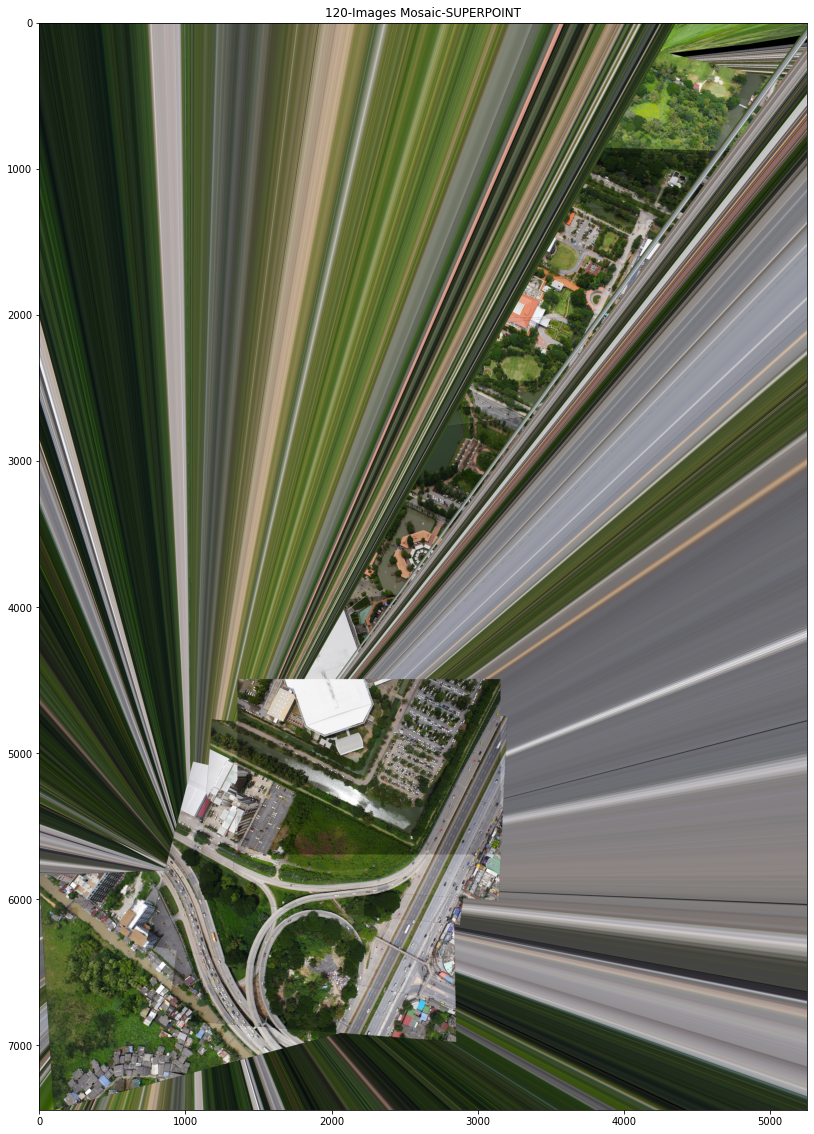

In [35]:
fig,ax =plt.subplots()
fig.set_size_inches(20,20)
ax.imshow(cv2.cvtColor(warp_imgs_all_superpoint , cv2.COLOR_BGR2RGB))
ax.set_title('120-Images Mosaic-SUPERPOINT')